In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-04-17 09:04:28--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.03s   

2020-04-17 09:04:29 (2.55 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



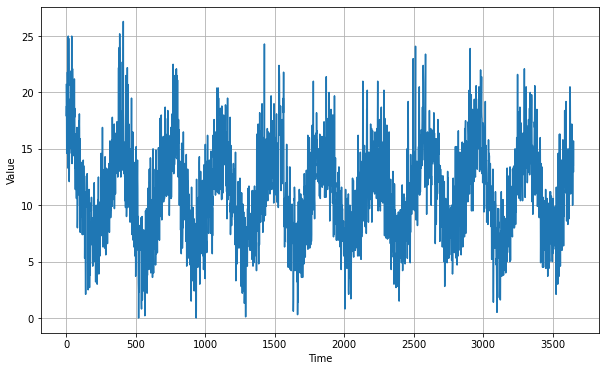

In [19]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
    # YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
    # HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
    reader = csv.reader(csvfile)
    next(reader)

    temps = [float(row[1]) for row in reader]
    time_step = list(range(1, len(temp)+1))

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda x: (x[:-1], x[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [22]:
np.max(series)

26.3

In [32]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

l = tf.keras.layers
model = tf.keras.models.Sequential([
    # YOUR CODE HERE
    l.Conv1D(32, 5, padding='causal', activation='relu', input_shape=[None, 1]),
    l.LSTM(64, return_sequences=True),
    l.LSTM(64, return_sequences=True),
    l.Dense(10, activation='relu'),
    l.Dense(10, activation='relu'),
    l.Dense(1),
    l.Lambda(lambda x: x * 40)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.summary()
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 10)          650       
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          110       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
____________________

In [39]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

KeyError: ignored

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
    l.Conv1D(32, 5, padding='causal', activation='relu', input_shape=[None, 1]),
    l.LSTM(64, return_sequences=True),
    l.LSTM(64, return_sequences=True),
    l.Dense(10, activation='relu'),
    l.Dense(10, activation='relu'),
    l.Dense(1),
    l.Lambda(lambda x: x * 40)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/200
25/25 [==============================] - 1s 31ms/step - loss: 3.9617 - mae: 4.4661
Epoch 2/200
25/25 [==============================] - 1s 31ms/step - loss: 2.5084 - mae: 2.9767
Epoch 3/200
25/25 [==============================] - 1s 31ms/step - loss: 2.1577 - mae: 2.6145
Epoch 4/200
25/25 [==============================] - 1s 32ms/step - loss: 1.9538 - mae: 2.4074
Epoch 5/200
25/25 [==============================] - 1s 31ms/step - loss: 1.8983 - mae: 2.3506
Epoch 6/200
25/25 [==============================] - 1s 31ms/step - loss: 1.8751 - mae: 2.3277
Epoch 7/200
25/25 [==============================] - 1s 31ms/step - loss: 1.8568 - mae: 2.3103
Epoch 8/200
25/25 [==============================] - 1s 32ms/step - loss: 1.8377 - mae: 2.2936
Epoch 9/200
25/25 [==============================] - 1s 32ms/step - loss: 1.8242 - mae: 2.2782
Epoch 10/200
25/25 [==============================] - 1s 32ms/step - loss: 1.8088 - mae: 2.2626
Epoch 11/200
25/25 [=============================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

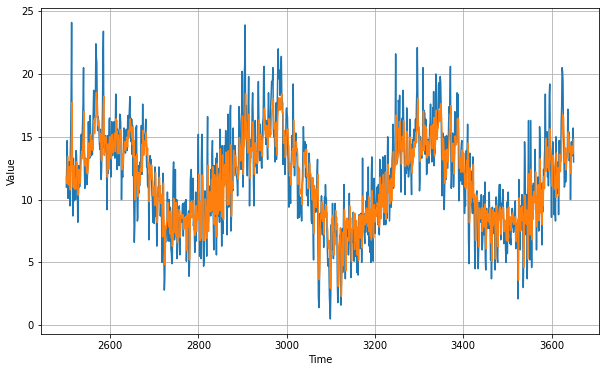

In [41]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [42]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7875979

In [43]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.787509 11.278534 12.296615 ... 13.637528 13.667741 14.802713]
